# Churn Prediction Model

### Load Relevant Packages and Data

In [1]:
#add packages
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#specific from Scikit-Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn import tree

#specific from IPython
from IPython.display import Image

In [2]:
#loading the data
churn_data=pd.read_csv("C:/Users/Joel/Text Mining/Churn Prediction Model/Telco-Customer-Churn.csv", sep=",")
churn_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#setting the target variable as Churn
target_name='Churn'
target_series=churn_data[target_name]

#remove the target from current position
churn_data.drop(columns='Churn',inplace=True)

#insert the target column in first row
churn_data.insert(0,target_name,target_series)
churn_data.head(5)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,No,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,...,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Yes,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,No,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,...,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Yes,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


### Exploratory Data Analysis

(7043, 45)
Churn                                        int32
SeniorCitizen                                int64
tenure                                       int64
MonthlyCharges                             float64
gender_Female                                uint8
gender_Male                                  uint8
Partner_No                                   uint8
Partner_Yes                                  uint8
Dependents_No                                uint8
Dependents_Yes                               uint8
PhoneService_No                              uint8
PhoneService_Yes                             uint8
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No in

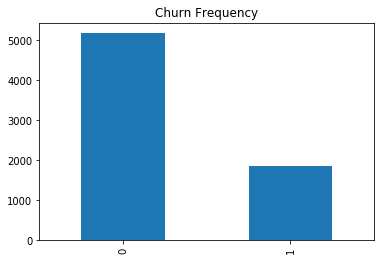

In [31]:
#number of rows and columns
print(churn_data.shape)

#data types of the variables included
print(churn_data.dtypes)

#graph for churn frequency
plt.title("Churn Frequency")
churn_data['Churn'].value_counts().plot(kind='bar')

Just wanted to a get an idea of the variables in the data set. We have 20 features and one target variable. Most of the features are in object type and will need to be converted to dummies for analysis. We also can look to the bar chart to confirm that we have enough of both "yes" and "no" within the target variable to train a robust model.

In [5]:
#checking for missing values in the columns
print(churn_data.isnull().sum())

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


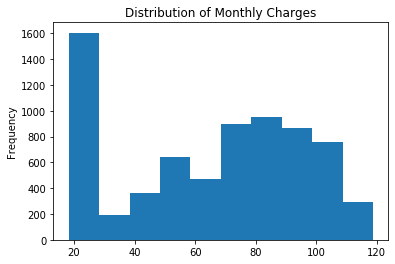

In [30]:
#histogram of the monthly charges
plt.title("Distribution of Monthly Charges")
churn_data.MonthlyCharges.plot.hist()

#### Observations:

* This dataset is very clean and has are no missing values. 
* The distribution of monthly charges indicates that a large portion of customers are the 20-30 dollar range. This is to be expected as telecommunication companies are always offering lowered prices to entice new customers. 
* Looking past that, there seems to be a normal distribution with a mid point around 70-80 dollars.

Text(0, 0.5, 'Count of Customers')

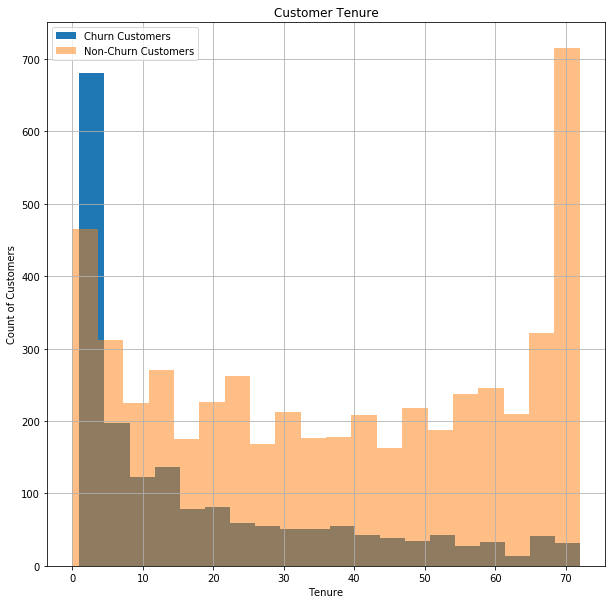

In [7]:
#looking at tenure distribution in churn -- code from https://www.kaggle.com/kitsdmit/customer-churn-eda-feature-engineering-and-model
fig, ax = plt.subplots(figsize = (10,10))
churn_data.tenure[churn_data.Churn == 'Yes'].hist(bins=20)
churn_data.tenure[churn_data.Churn == 'No'].hist(bins=20, alpha=0.5)
plt.legend(['Churn Customers', 'Non-Churn Customers'])
plt.title('Customer Tenure')
plt.xlabel('Tenure')
plt.ylabel('Count of Customers')

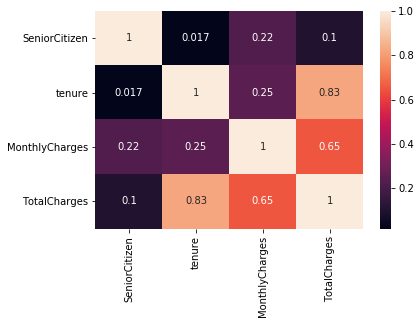

In [8]:
#converting Total Charges to a numeric value
churn_data["TotalCharges"] = pd.to_numeric(churn_data.TotalCharges, errors='coerce')

##corr matrix of all numeric variables
cor_matrix=churn_data.corr()

#visual corr matrix
sn.heatmap(cor_matrix, annot=True)

# fix for mpl bug that cuts off top/bottom of seaborn viz (Code by Salmac86 https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim()
b += 0.5
t -= 0.5 
plt.ylim(b, t) 

#draw the matrix
plt.show()

Bar Charts for all Categorical Variables


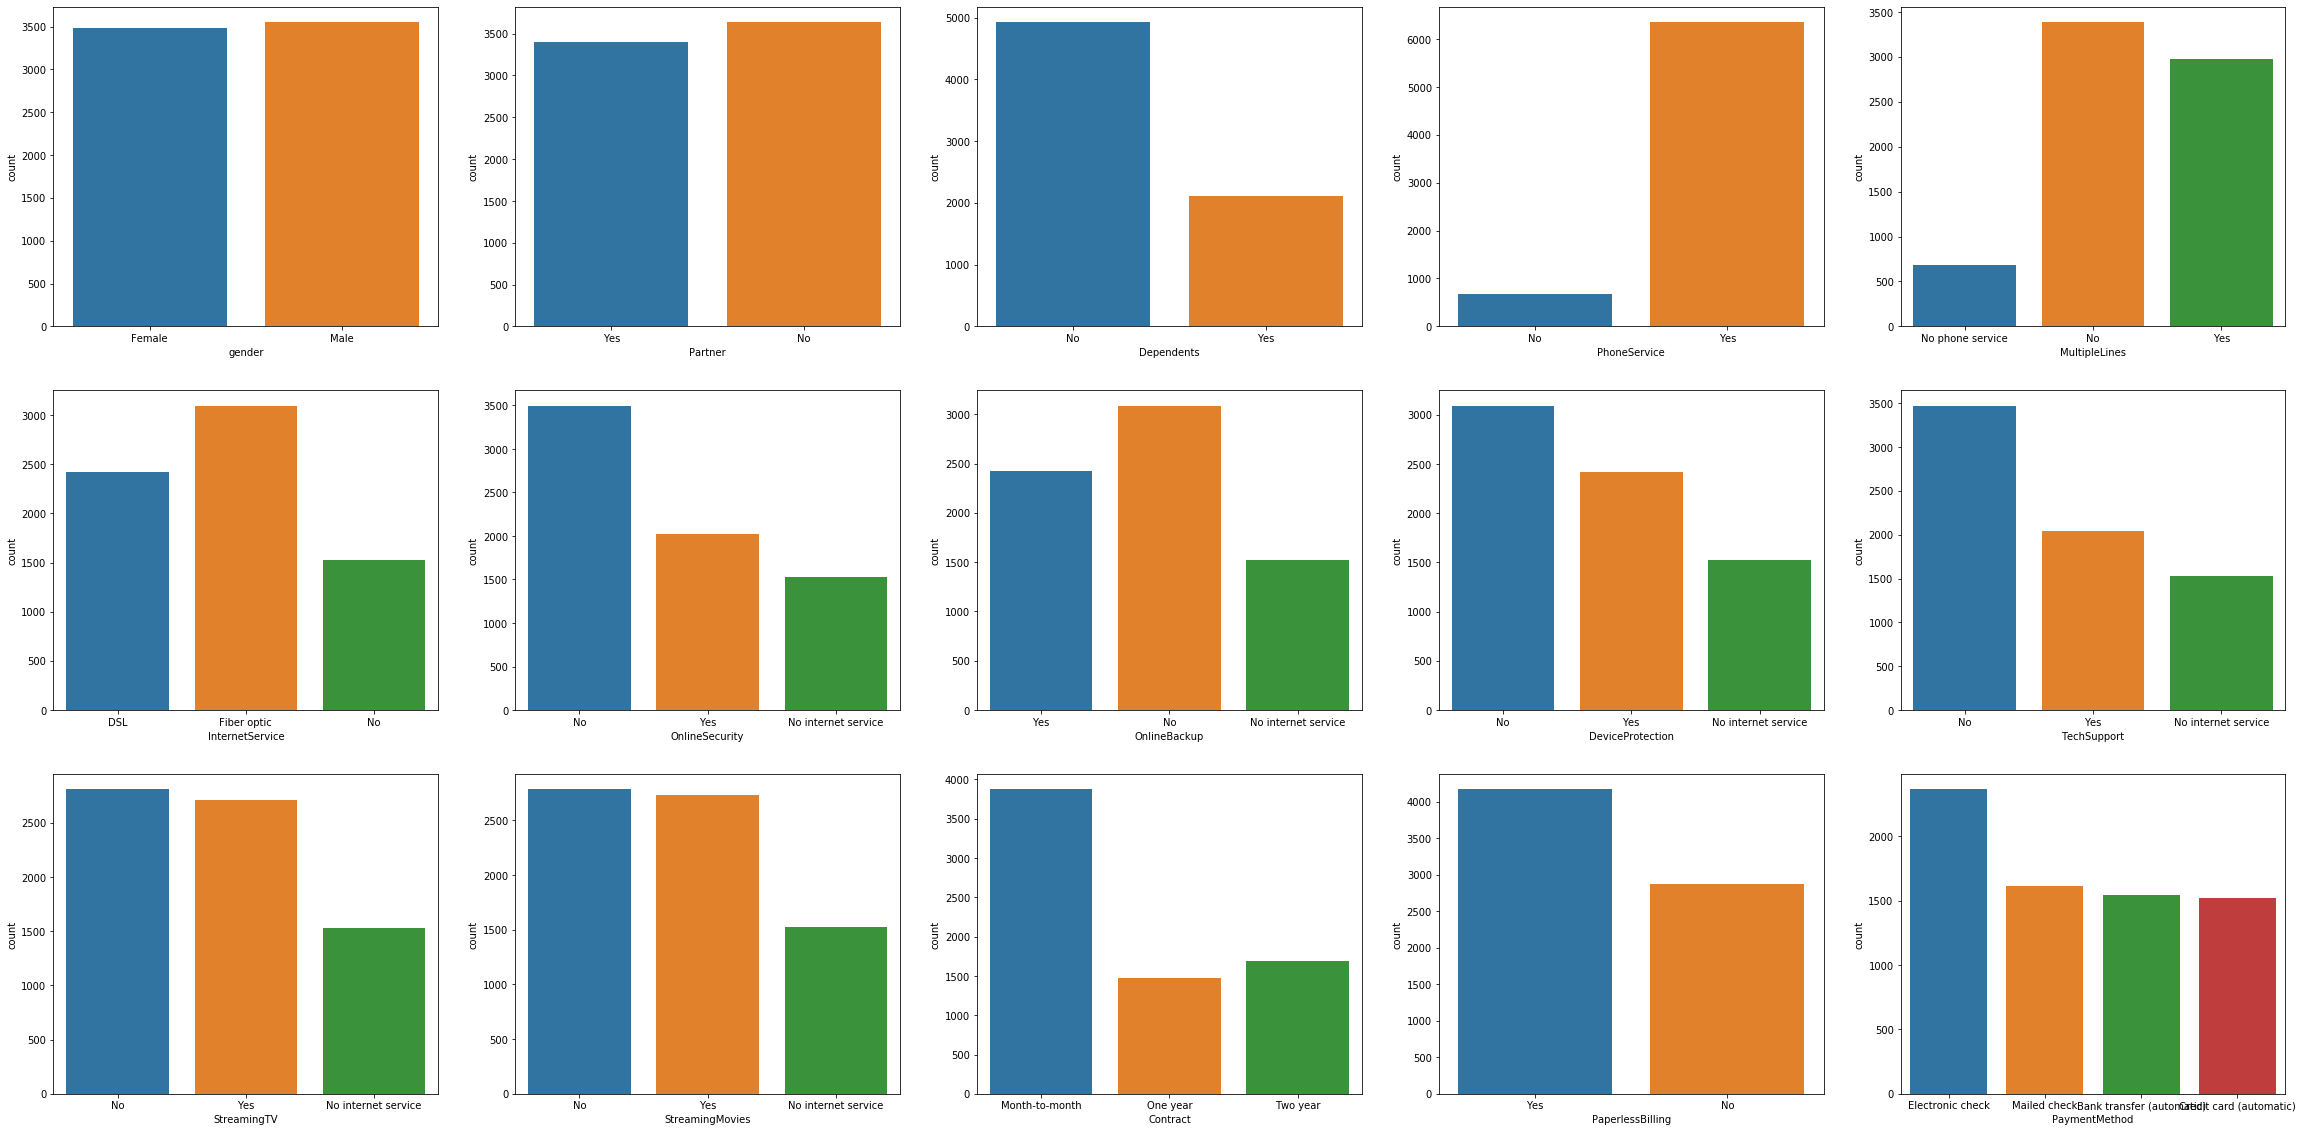

In [10]:
#visualizing all the categorical features
#creating list of all columns
columns_bar= churn_data.select_dtypes(include=object)
columns_bar= list(columns_bar.columns)
columns_bar.remove('Churn')
columns_bar.remove('customerID')

#creating a matrix to display all charts
columns_bar_array = np.array(columns_bar)
columns_bar_array = np.reshape(columns_bar_array, (3,5))

#plotting the bar charts
rows = 3 ; columns = 5
f, axes = plt.subplots(rows, columns, figsize=(40,20))
print ("Bar Charts for all Categorical Variables")
for row in range(rows):
    for column in range(columns):
        sn.countplot(churn_data[columns_bar_array[row][column]], ax = axes[row, column])

#### Observations:
* As expected the total charges show a high correaltion with Tenure. This is because total charges is really a product of monthly charges and tenure
* Split between male/female and partner/no partner is about equal
* Most (over 4,000) customers pay electronically
* Most customers prefer a no contract, month to month plan

#### Potential Extra Features:
* Partnered and having kids probably means being a family unit
* Subsribing to our phone service, internet service, streaming TV and streaming movies means that we are their sole provider or at least their main provider. 

### Preproccessing 

In [11]:
#taking out total charges and customer ID
churn_data = churn_data.drop(['TotalCharges', 'customerID'], axis=1)
churn_data.head(5)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,No,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,No,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Yes,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,No,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,Yes,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


In [12]:
# This code turns a text target into numeric to some scikit learn algorithms can process it
le_dep = preprocessing.LabelEncoder()

# to convert into numbers
churn_data['Churn'] = le_dep.fit_transform(churn_data['Churn'])

In [13]:
# perform data transformation. Creates dummies of any categorical feature
for col in churn_data.columns[1:]:
	attName = col
	dType = churn_data[col].dtype
	missing = pd.isnull(churn_data[col]).any()
	uniqueCount = len(churn_data[attName].value_counts(normalize=False))

# discretize (create dummies)
	if dType == object:
		churn_data= pd.concat([churn_data, pd.get_dummies(churn_data[col], prefix=col)], axis=1)
		churn_data.drop(columns=[attName],inplace=True)
churn_data

,Churn,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,34,56.95,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,1,0,2,53.85,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,0,45,42.30,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,1,0,2,70.70,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,24,84.80,0,1,0,1,0,1,...,1,0,1,0,0,1,0,0,0,1
7039,0,0,72,103.20,1,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0
7040,0,0,11,29.60,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
7041,1,1,4,74.40,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [14]:
# split dataset into testing and training
features_train, features_test, target_train, target_test = train_test_split(churn_data.iloc[:,1:].values, 
                                                                            churn_data.iloc[:,0].values, test_size=0.40, 
                                                                            random_state=0)

## Modeling

### Decision Trees - Base Model

In [15]:
#Decision Tree train model. Call up my model and name it churn_dt
churn_dt = tree.DecisionTreeClassifier()

#Fit DT model to the training data
churn_dt = churn_dt.fit(features_train, target_train)

#Predict DT model again test data
target_predicted_dt = churn_dt.predict(features_test)

#looking at the accuracy of this model
print("DT Accuracy Score", accuracy_score(target_test, target_predicted_dt))
print(classification_report(target_test, target_predicted_dt))
print(confusion_matrix(target_test, target_predicted_dt))

DT Accuracy Score 0.7334989354151881
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2071
           1       0.50      0.51      0.50       747

    accuracy                           0.73      2818
   macro avg       0.66      0.66      0.66      2818
weighted avg       0.74      0.73      0.73      2818

[[1685  386]
 [ 365  382]]


Base model is able to identify 73% of the variability in the data. Pretty low recall for churn data. 

In [16]:
churn_dt_2 = tree.DecisionTreeClassifier(criterion="entropy")
#Fit clf to the training data
churn_dt_2 = churn_dt_2.fit(features_train, target_train)
#Predict DT model again test data
target_predicted_dt_2 = churn_dt_2.predict(features_test)
#looking at the accuracy of this model
print("DT Accuracy Score", accuracy_score(target_test, target_predicted_dt_2))
print(classification_report(target_test, target_predicted_dt_2))
print(confusion_matrix(target_test, target_predicted_dt_2))

DT Accuracy Score 0.7324343506032647
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2071
           1       0.50      0.49      0.49       747

    accuracy                           0.73      2818
   macro avg       0.66      0.66      0.66      2818
weighted avg       0.73      0.73      0.73      2818

[[1695  376]
 [ 378  369]]


In [17]:
churn_dt_3 = tree.DecisionTreeClassifier(criterion="entropy",splitter="random")
#Fit clf to the training data
churn_dt_3 = churn_dt_3.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_dt_3 = churn_dt_3.predict(features_test)
#looking at the accuracy of this model
print("DT Accuracy Score", accuracy_score(target_test, target_predicted_dt_3))
print(classification_report(target_test, target_predicted_dt_3))
print(confusion_matrix(target_test, target_predicted_dt_3))

DT Accuracy Score 0.7239176721078779
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2071
           1       0.48      0.46      0.47       747

    accuracy                           0.72      2818
   macro avg       0.64      0.64      0.64      2818
weighted avg       0.72      0.72      0.72      2818

[[1696  375]
 [ 403  344]]


Changing the strategy by which splits are chose did not seem to enhance results. THe best splitter is a better criteria on picking splits. It might be that this tree is not not very deep therefore, making it random makes it much more variable.

In [18]:
#verify decision trees using cross validation
scores_dt = cross_val_score(churn_dt_2, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores_dt)
scores_dt.mean()

Cross Validation Score for each K [0.74764151 0.74056604 0.71158392 0.72985782 0.71327014 0.75592417
 0.73459716 0.7535545  0.74407583 0.74881517]


0.7379886258249551

The model we cross validated is doing a good job of generalizing the data. We do not have overfitting occuring. The cross validation suggests a accuracy score of 73 percent is what we should expect but the model came in right around there.

# Stochastic Gradient Descent

In [19]:
#import the packages necessary for SGD
from sklearn.linear_model import SGDClassifier
#call the SGD classifier 
churn_sgd = SGDClassifier(class_weight='balanced', random_state=0)
#Fit to the training data
churn_sgd = churn_sgd.fit(features_train, target_train)
#Predict using SGD to test data
target_predicted_sgd = churn_sgd.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_sgd))
print(classification_report(target_test, target_predicted_sgd))
print(confusion_matrix(target_test, target_predicted_sgd))

Accuracy Score 0.4744499645138396
              precision    recall  f1-score   support

           0       0.98      0.29      0.45      2071
           1       0.33      0.98      0.50       747

    accuracy                           0.47      2818
   macro avg       0.66      0.64      0.47      2818
weighted avg       0.81      0.47      0.46      2818

[[ 603 1468]
 [  13  734]]


The initial gradient descent model has a poor accuracy score. it is only able to explain 47 percent of variance in the data. Most of the this comes from it's impeccable ability to be precise with the No's and recall all the Yes's. We will tune a few hyperparameters in order to increase predictive power. 

In [20]:
#create parameters to test
parameters_sgd = {'penalty':('l1', 'l2','elasticnet'), 'alpha':[.001,.01,.1,1],'loss':['hinge','squared_hinge','modified_huber']}
#call the model 
sgd = SGDClassifier(class_weight='balanced',random_state=0)
#test the model with the parameters
grid_sgd = GridSearchCV(sgd, parameters_sgd, cv=5)
grid_sgd.fit(features_train, target_train)
#results
print("BEST SCORE",grid_sgd.best_score_)
print("BEST PARAM", grid_sgd.best_params_)

C:\Users\Joel\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


BEST SCORE 0.7808284023668639
BEST PARAM {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'elasticnet'}


In [21]:
#call the SGD classifier 
churn_sgd_2 = SGDClassifier(alpha=.001,class_weight='balanced',random_state=0)
#Fit to the training data
churn_sgd_2 = churn_sgd_2.fit(features_train, target_train)
#Predict using SGD to test data
target_predicted_sgd_2 = churn_sgd_2.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_sgd_2))
print(classification_report(target_test, target_predicted_sgd_2))
print(confusion_matrix(target_test, target_predicted_sgd_2))

Accuracy Score 0.7863733144073811
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2071
           1       0.70      0.34      0.46       747

    accuracy                           0.79      2818
   macro avg       0.75      0.64      0.66      2818
weighted avg       0.77      0.79      0.76      2818

[[1964  107]
 [ 495  252]]


Changing the alpha to .001 helped tremendenously in increasing the predicitive power of the model. The only downside to this model is that the recall for the positive prediticions is pretty poor. Fine tuning the loss funtion and penalty parameters should help.

In [22]:
#call the SGD classifier 
churn_sgd_3 = SGDClassifier(loss='hinge',penalty='elasticnet',
                            alpha=.001,class_weight='balanced',random_state=0)
#Fit to the training data
churn_sgd_3 = churn_sgd_3.fit(features_train, target_train)
#Predict using SGD to test data
target_predicted_sgd_3 = churn_sgd_3.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_sgd_3))
print(classification_report(target_test, target_predicted_sgd_3))
print(confusion_matrix(target_test, target_predicted_sgd_3))

Accuracy Score 0.7959545777146912
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2071
           1       0.66      0.46      0.55       747

    accuracy                           0.80      2818
   macro avg       0.75      0.69      0.71      2818
weighted avg       0.78      0.80      0.78      2818

[[1896  175]
 [ 400  347]]


In [23]:
#verify the linear SVM model using cross validation
scores_sgd = cross_val_score(churn_sgd_3, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores_sgd)
scores_sgd.mean() 

Cross Validation Score for each K [0.75       0.44339623 0.77777778 0.75118483 0.52606635 0.62322275
 0.56161137 0.77014218 0.74170616 0.67298578]


0.6618093435472493

The last model performed significanly better. It was able to explain 80 percent of the variance in the data. Looking at the cross validation test, we see that on average the model was predicting much less which means our model is overfitting. Might be due to the class imbalance. 

# SVM Linear

In [24]:
#import packages neccessary for analysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#call the model and create class
churn_lnsvm=LinearSVC(random_state=0,dual=False)
#Fit churn to the training data
churn_lnsvm = churn_lnsvm.fit(features_train, target_train)
#Predict churn SVM linear model to test data
target_predicted_lnsvm = churn_lnsvm.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_lnsvm))
print(classification_report(target_test, target_predicted_lnsvm))
print(confusion_matrix(target_test, target_predicted_lnsvm))

Accuracy Score 0.8023420865862314
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2071
           1       0.66      0.54      0.59       747

    accuracy                           0.80      2818
   macro avg       0.75      0.72      0.73      2818
weighted avg       0.79      0.80      0.80      2818

[[1861  210]
 [ 347  400]]


This model is exceptional at predicting the "no", the precision and recall are proof of that. This model is also very poor prediciting the "Yes". The recall for the positive prediction is horrilbe. The dual has been turned to false to prevent the max_iter error. One point to note here, is that classes have not been weighted properly therefore, we should be able to get better results for predicting the YES values.

In [25]:
parameters = {'C':[.001,.01,1,3,5,10]}
svr = LinearSVC(random_state=0, dual=False)
grid_lnsvm = GridSearchCV(svr, parameters, cv=5)
grid_lnsvm.fit(features_train, target_train)
print("BEST SCORE",grid_lnsvm.best_score_)
print("BEST PARAM", grid_lnsvm.best_params_)

BEST SCORE 0.8035502958579882
BEST PARAM {'C': 0.001}


The parameter being tested is the penalty. The best model is a result of the regularization being .001 and all other hyperparameters remaining.

In [26]:
#call the model and create class with a balanced class this time
churn_lnsvm_2=LinearSVC(class_weight='balanced',random_state=0,dual=False)
#Fit churn to the training data
churn_lnsvm_2 = churn_lnsvm_2.fit(features_train, target_train)
#Predict churn random forest model to test data
target_predicted_lnsvm_2 = churn_lnsvm_2.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_lnsvm_2))
print(classification_report(target_test, target_predicted_lnsvm_2))
print(confusion_matrix(target_test, target_predicted_lnsvm_2))

Accuracy Score 0.7388218594748048
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      2071
           1       0.50      0.79      0.62       747

    accuracy                           0.74      2818
   macro avg       0.70      0.76      0.71      2818
weighted avg       0.80      0.74      0.75      2818

[[1491  580]
 [ 156  591]]


The overall accuracy of the model fell but we were able to drasitically improve the recall of the positive values found and the precision of the negative values. This model however is worse at precision of positive values and recall of negative values.

In [27]:
#call the model and create class with the regularization 
churn_lnsvm_3=LinearSVC(C=.001,class_weight='balanced',random_state=0, dual=False)
#Fit to the training data
churn_lnsvm_3 = churn_lnsvm_3.fit(features_train, target_train)
#Predict using svm to test data
target_predicted_lnsvm_3 = churn_lnsvm_3.predict(features_test)
#looking at the accuracy of this model
print("Accuracy Score", accuracy_score(target_test, target_predicted_lnsvm_3))
print(classification_report(target_test, target_predicted_lnsvm_3))
print(confusion_matrix(target_test, target_predicted_lnsvm_3))

Accuracy Score 0.747693399574166
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      2071
           1       0.52      0.78      0.62       747

    accuracy                           0.75      2818
   macro avg       0.71      0.76      0.72      2818
weighted avg       0.80      0.75      0.76      2818

[[1524  547]
 [ 164  583]]


In [28]:
#verify the linear SVM model using cross validation
scores_lnsvm = cross_val_score(churn_lnsvm, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores_lnsvm)
scores_lnsvm.mean() 

Cross Validation Score for each K [0.79481132 0.80660377 0.78959811 0.81990521 0.78909953 0.78909953
 0.79383886 0.79620853 0.78909953 0.85308057]


0.8021344956641169

The best model in this scenario was the first base model created. All hyperparameters were set to their default. The only one that I altered was using dual optimization as the data set has much more samples than features. This led to the best model, being able to predict 80 percent of the variance in the model.

# Feature Importance

Top 10 Features Impacts


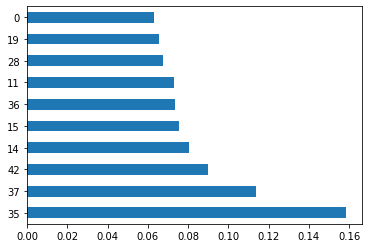

In [29]:
print('Top 10 Features Impacts')
pd.Series(abs(churn_lnsvm_3.coef_[0])).nlargest(10).plot(kind='barh')